# Rubin ToO Strategies

Notebook template author: Igor Andreoni <igor.andreoni@gmail.com>

This notebook was put together to aid visualization of possible strategies to adopt for Target of Opportunity (ToO) observations with Vera C. Rubin Observatory. The template code was used to produce some figures published in Andreoni et al. (2022), The Astrophysical Journal Supplement Series, Volume 260, Issue 1, id.18, 17 pp.

### Requirements

Python3

- numpy
- matplotlib
- math
- collections

Custom scripts
- chart.py
- etc.py

### Run the cells

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import OrderedDict
import pandas as pd

# Import the custom exposure time calculator
import etc

# Import the function to make the Gantt chart
from chart import makeChart

Build a dictionary with the strategies that you want to be seen on the same plot. 
The keys of the dictionary will be the nicknames of the strategies (for example, `strategy1`, `strategy2`).

Notes:
- The LSSTCam filter wheel holds 5 filters on a given night. The bluer and redder filters, u and y, will be swapped depending on the lunation. If all 6 filters are added to the plot, we shall assume that 5 available filters will be used in the ToOs.
- The length of the exposure time list (`exptimes` key) must be the same length as the cadence list (`cadence_hr` key) and the filters list (`filters` key)
- The cadence must be given in hours, the exposure times in seconds, the filters as a list or in the form `'ugrizy'`
- The `depths` are 5sigma limiting magnitudes in all bands, the corresponding exptime will be the median of the exposure times for the filters provided in each strategy
- <b>Important:</b> If both "depths" and "exposures" are given, "depths" will dominate.

In [2]:
strategies = {
    'Strategy 1 blue': {"cadence_hr": [1, 4, 24, 48],
                   "exptimes": [30, 30, 60, 180],
                   "depths": [24.5, 24.5, 24.5, 24.5],
                   "filters": ['ugr', 'ugr', 'g', 'g']},
    'Strategy 1 red': {"cadence_hr": [1, 4, 24, 48],
                   "exptimes": [30, 30, 60, 180],
                   "depths": [24.5, 24.5, 24.5, 24.5],
                   "filters": ['izy', 'izy', 'z', 'z']},
    'Fabulous Strategy': {"cadence_hr": [4, 24, 48],
                   "exptimes": [],
                   "depths": [24.5, 25, 25],
                   "filters": ['ugrizy', 'ugrizy', 'ugrizy']},
    #'Strategy 3': {"cadence_hr": [1, 4, 24],
    #               "exptimes": [],
    #               "depths": [24, 24, 24],
    #               "filters": ['ugrizy', 'ugrizy', 'gz']},
}

# When is the timeline starting? e.g., Rubin Trigger, NS-NS merger, ...
event_name = "start of Rubin observing window"

# Output file name
filename_out = "plot_strategy.pdf"

# Define the colors for the Rubin filters
filters_color_dict = {'u':'b', 'g':'g', 'r':'r', 'i':'yellow', 'z':'k', 'y':'orange'}

# Define the sequence of markers for different exposure times
# (the sequence will be ordered by increasing exposure time)
exptimes_marker_list = ["o", "s", "p", "h", "8", '^']

### Plot the Gantt chart

The figure is AFTER the printed text and saved to file

 Strategy name: Strategy 1 blue
Using DEPTHS to calculate the exposure times
    Epoch: 24.5 hr
        Filter: u Depth: 24.5mag, exptime: 131s
        Filter: g Depth: 24.5mag, exptime: 13s
        Filter: r Depth: 24.5mag, exptime: 29s
Median exposure time: 29s
    Epoch: 24.5 hr
        Filter: u Depth: 24.5mag, exptime: 131s
        Filter: g Depth: 24.5mag, exptime: 13s
        Filter: r Depth: 24.5mag, exptime: 29s
Median exposure time: 29s
    Epoch: 24.5 hr
        Filter: g Depth: 24.5mag, exptime: 13s
Median exposure time: 13s
    Epoch: 24.5 hr
        Filter: g Depth: 24.5mag, exptime: 13s
Median exposure time: 13s

 Strategy name: Strategy 1 red
Using DEPTHS to calculate the exposure times
    Epoch: 24.5 hr
        Filter: i Depth: 24.5mag, exptime: 60s
        Filter: z Depth: 24.5mag, exptime: 170s
        Filter: y Depth: 24.5mag, exptime: 1088s
Median exposure time: 170s
    Epoch: 24.5 hr
        Filter: i Depth

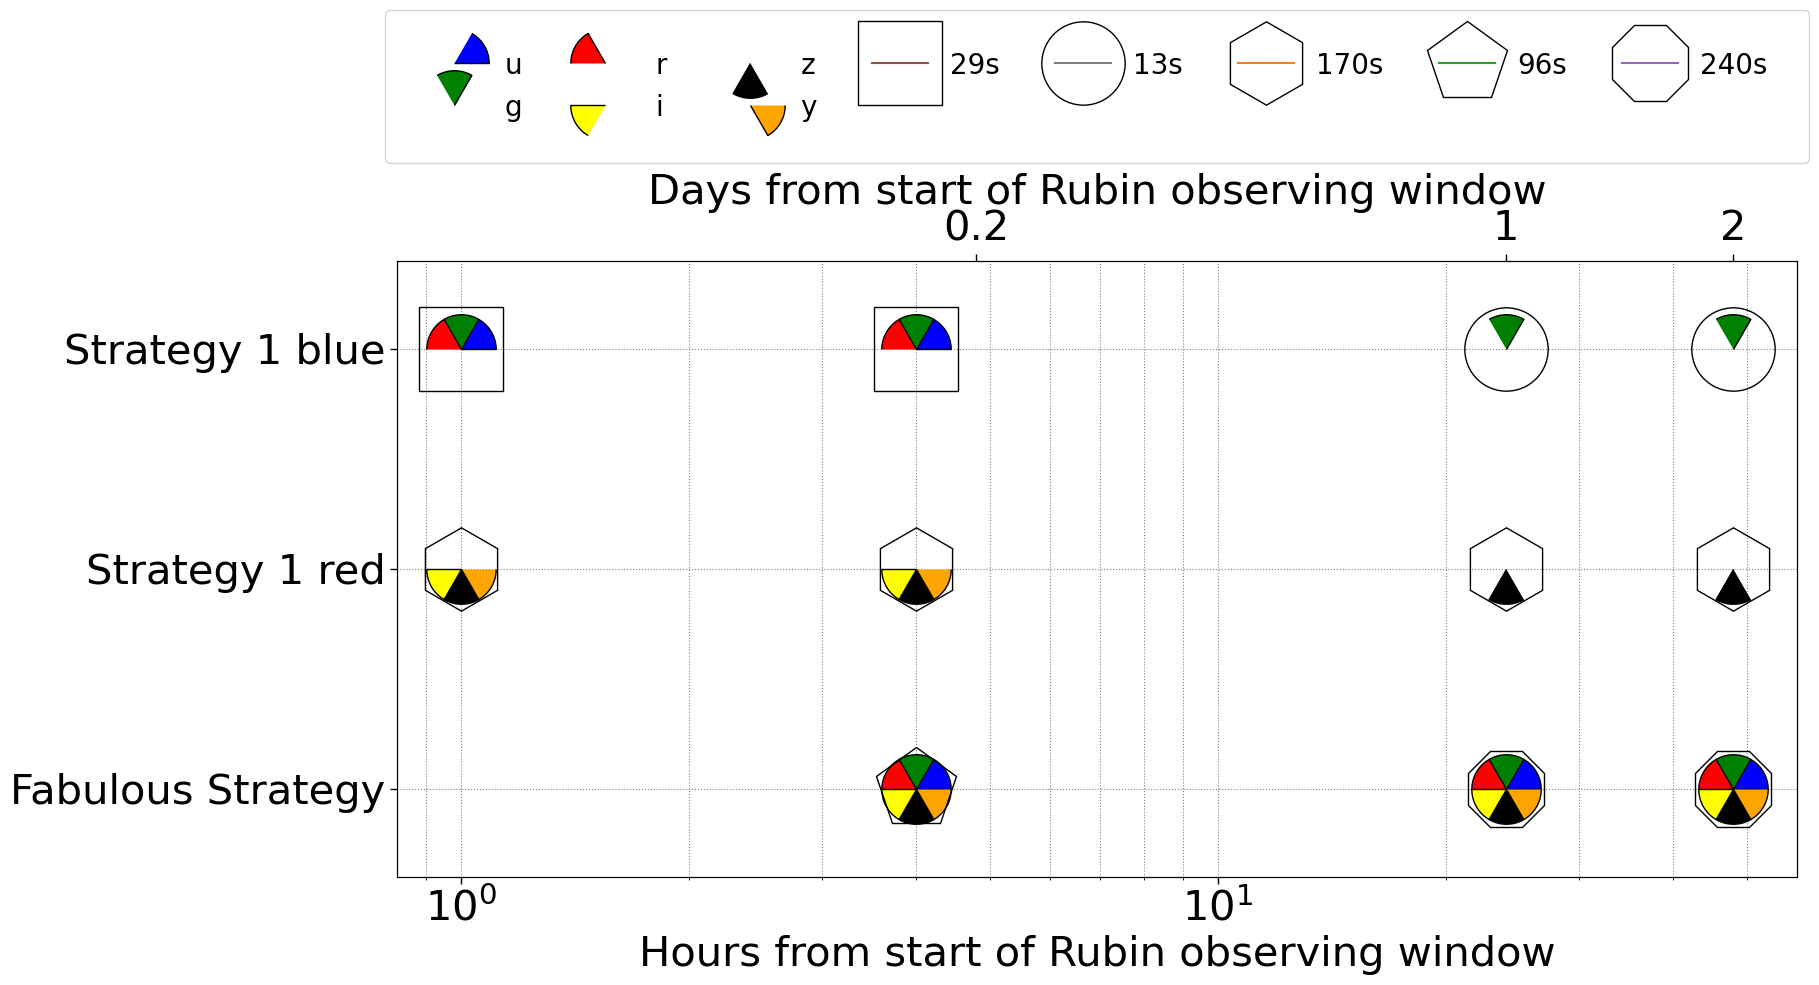

In [3]:
# If depths are given, then compute the exposure times
strategy_names = list(strategies.keys())
print("The figure is AFTER the printed text and saved to file")
for i in range(len(strategy_names)):
    print(f"\n Strategy name: {strategy_names[i]}")
    if len(strategies[strategy_names[i]]["depths"]) > 0:
        print("Using DEPTHS to calculate the exposure times")
        # Initiate the exposure times list
        strategies[strategy_names[i]]["exptimes"] = []
        #Get exposure times, print results:
        for j in np.arange(len(strategies[strategy_names[i]]["depths"])):
            depth = strategies[strategy_names[i]]["depths"][j]
            # Iterate over the filters
            exptimes_epoch = [] # Get the average exposure time for a given epoch 
            print(f"    Epoch: {strategies[strategy_names[i]]['depths'][j]} hr")
            for filt in strategies[strategy_names[i]]["filters"][j]:
                exptime = int(np.round(etc.get_exptime(depth, filt)))
                print(f"        Filter: {filt} Depth: {depth}mag, exptime: {exptime}s")
                exptimes_epoch.append(exptime)
            # Add the average exposure time to the strategies dictionary
            strategies[strategy_names[i]]["exptimes"].append(int(np.round(np.median(exptimes_epoch))))
            print(f"Median exposure time: {int(np.round(np.median(exptimes_epoch)))}s")
    else:
        print("Using EXPOSURE TIMES to calculate the depths")

# Create the gantt chart
fig, ax = makeChart(strategies, event=event_name,
                    filters_color_dict=filters_color_dict,
                    exptimes_marker_list=exptimes_marker_list)

# Save the figure and show the plot
plt.savefig(filename_out, bbox_inches='tight')
plt.show()

### Plot transient light curve 
# Work in progress

Plot the light curve of a transient given the strategy defined above.

In [4]:
import glob

import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt
from scipy import interpolate
from matplotlib.ticker import MaxNLocator
from astropy.cosmology import Planck18 as cosmo
import astropy.cosmology as ac
import astropy.units as u

import plot_lc

For plotting kilonovae, choose relevant parameters

Models come in CSV or ASCII files. check out the `/models` folder and copy the format if you want to add your favorite model.

One important parameter is `delay_hr`, which is the delay time between the onset of the transient (e.g., the merger of two compact objects) and the start of the observability window. Note that `cadence_hr` starts from the beginning of the observability window, since we cannot predict when the onset is, if the event happens during the Chilean daytime.

In [5]:
# redshift
z = 0.01

delay_hr = 6.

model_filename = "models/kilonova_Bulla/nph1.0e+06_dyn0.001-0.15-0.20_wind0.050-0.03_theta25.84_z0.2.dat"


 Strategy name: Strategy 1 blue


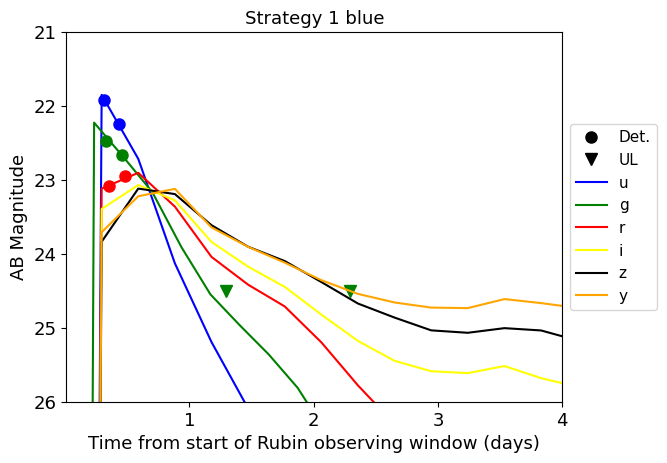


 Strategy name: Strategy 1 red


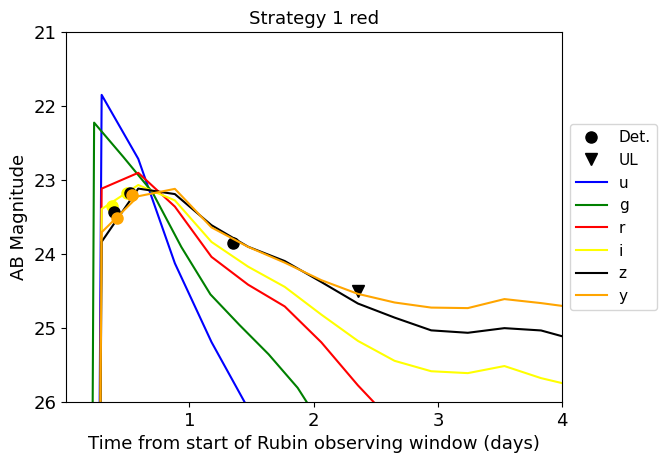


 Strategy name: Fabulous Strategy


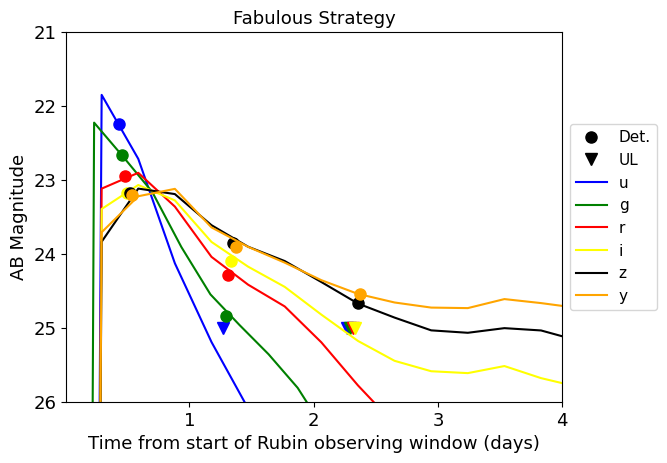

In [6]:
t_model = ascii.read(model_filename)
plot_lc.doPlotLc(strategies, t_model,
                 delay_hr,  # delay time between merger and observing window
                 xlim=[0.01, 4], # x axis limit in apparent mag
                 ylim=[26, 21],  # y axis limit in apparent mag
                 n_interp=100,  # Number of points for the interpolation (e.g. 150)
                 offset_filt_hr=0.5,  # offset in hours between filters (to show overlapping points)
                 outfile_base="plot_lc",  # Base name for the file to be saved
                 outfile_format='pdf',  # Format of the output plot (pdf, png, etc)
                 doSave=True,  # If set to False, the plot will not be saved
                 event_name=event_name,  # Name of the event for the X label
                 linestyle="-",
                 filters_color_dict=filters_color_dict)

### Time budget (WIP!!!)

Based on the strategies adopted, compute the time budget

In [7]:
for i in range(len(strategy_names)):
    print(f"\n Strategy name: {strategy_names[i]}")
    depths = strategies[strategy_names[i]]["depths"]


 Strategy name: Strategy 1 blue

 Strategy name: Strategy 1 red

 Strategy name: Fabulous Strategy
